In [9]:
% matplotlib inline

In [76]:
import matplotlib.pyplot as plt

In [3]:
# properties

colors = 8
shapes = 12
locs = 9

# todo: add rotation

props = colors + shapes + locs
configs = colors * shapes * locs
print(props, configs)

11 25


In [2]:
import math

for n in range(1, 8):
    print("situations(n_objects={}): {:>27,}".format(n, int(math.pow(configs, n))))

situations(n_objects=1):                         864
situations(n_objects=2):                     746,496
situations(n_objects=3):                 644,972,544
situations(n_objects=4):             557,256,278,016
situations(n_objects=5):         481,469,424,205,824
situations(n_objects=6):     415,989,582,513,831,936
situations(n_objects=7): 359,414,999,291,950,792,704


In [3]:
import json

task_file_path = "../tests/generated/tasks.json"


def load_tasks():
    with open(task_file_path) as f:
        return json.load(f)

In [6]:
tasks = load_tasks()

In [28]:
import collections


# Do we have a balanced distribution over property values?
# Count prop value frequencies
# Can also be seen as distribution of X
def count_prop_val_freq(tasks):
    freqs = collections.defaultdict(int)
    for task in tasks:
        for piece in task["pieces"]:
            freqs[piece["type"]] = freqs[piece["type"]] + 1
            freqs[piece["color"]] = freqs[piece["color"]] + 1
            freqs[piece["posRelBoard"]] = freqs[piece["posRelBoard"]] + 1
    return freqs


props_value_freqs = count_prop_val_freq(tasks)

In [33]:
import pandas as pd


def prop_val_to_prop(prop_val):
    if prop_val in ["red", "orange", "yellow", "green", "blue", "purple", "saddlebrown", "grey"]:
        return "color"
    if prop_val in ["F", "I", "L", "N", "P", "T", "U", "V", "W", "X", "Y", "Z"]:
        return "shape"
    return "posRelBoard"


# easier to consume for pandas as list of dicts
df_props = pd.DataFrame.from_records(
    [{"PropVal": k, "Count": v, "Prop": prop_val_to_prop(k)} for k, v in props_value_freqs.items()])

/Users/philippsadler/Opts/Apps/anaconda3/envs/golmi/lib/python3.9/site-packages/seaborn/categorical.py:3808: UserWarning: Setting `sharey=False` with `color=None` may cause different levels of the `y` variable to share colors. This will change in a future version.
  warnings.warn(msg.format("sharey", "y"), UserWarning)


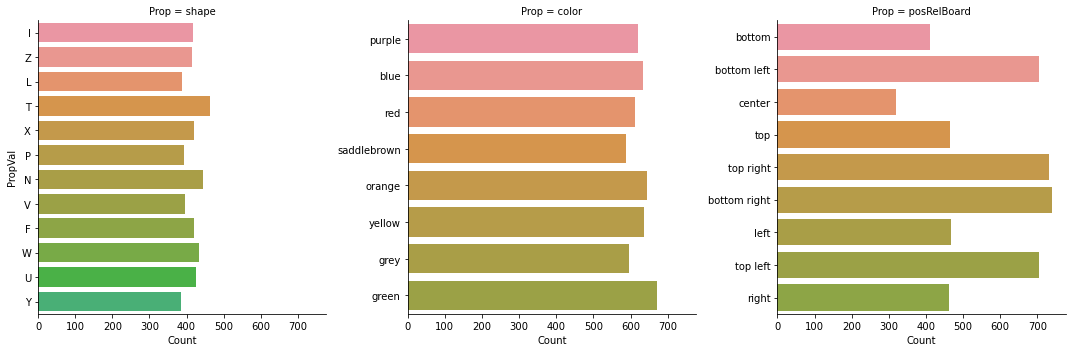

In [40]:
import seaborn as sns

# easier to plot if pandas frame
sns.catplot(x="Count", y="PropVal", col="Prop", kind="bar", data=df_props, orient="h", sharey=False)

Note: The property value distribution looks line. There are not really outliers. The locations are disbalanced, because we divide the areas by 3, so that the corner become bigger.

In [41]:
# Do we have a balanced distribution over selected targets?
# Count unique targets (based on props)
# Do we have targets for all possible (864) configs? Or at least an even amount over the existing ones?
# Can also be seen as distribution of X
def target_prop_val_freq(tasks):
    freqs = collections.defaultdict(int)
    for task in tasks:
        piece = task["target"]
        freqs[(piece["type"], piece["color"], piece["posRelBoard"])] += 1
    return freqs


target_freqs = target_prop_val_freq(tasks)
print(len(target_freqs), len(target_freqs) / float(864))

571 0.6608796296296297


Note: We only have 66% individual targets on 1,000 tasks. This might actually be an issue. We would rather like to have a factor of 10 more. Thus we rather need 10,000 tasks.

In [43]:
# easier to consume for pandas as list of dicts
df_target_props = pd.DataFrame.from_records(
    [{"Config": idx, "Count": v} for idx, (k, v) in enumerate(target_freqs.items())])

<AxesSubplot:xlabel='Config', ylabel='Count'>

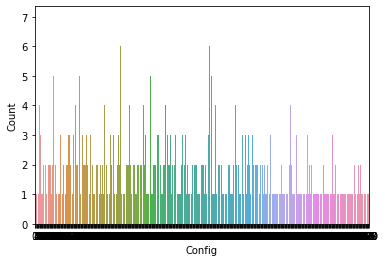

In [46]:
# easier to plot if pandas frame
sns.barplot(x="Config", y="Count", data=df_target_props)

<AxesSubplot:xlabel='Count', ylabel='Count'>

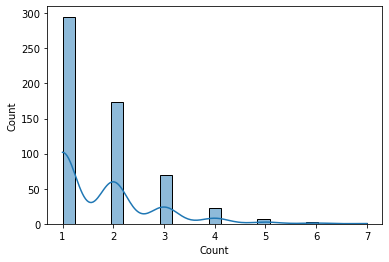

In [49]:
sns.histplot(df_target_props.Count, kde=True)

In [60]:
# For a single situation we still have multiple refs
# How many distinct refs (based on included props) do we have on average?
# Can also be seen as distribution of Y (label frequencies)
def refs_uniq_freq(tasks):
    freqs = []
    for task in tasks:
        task_refs = set()
        for ref in task["refs"]:
            # order should not matter (we sort before)
            props = list(ref["props"].keys())
            props.sort()
            task_refs.add(tuple(props))  # list is not hashable, but tuple is
        freqs.append(task_refs)
    return freqs


refs_uniq_freqs = refs_uniq_freq(tasks)
total_uniq_refs = set([r for refs in refs_uniq_freqs for r in refs])
print(len(total_uniq_refs), len(total_uniq_refs) / float(7))

7 0.007


In [61]:
total_uniq_refs

{('color',),
 ('color', 'posRelBoard'),
 ('color', 'posRelBoard', 'shape'),
 ('color', 'shape'),
 ('posRelBoard',),
 ('posRelBoard', 'shape'),
 ('shape',)}

Note: We actually see all output scenarios here. The order of properties is not important for the language template.

In [65]:
df_refs_uniq = pd.DataFrame.from_records(
    [{"Situation": idx, "Count": len(refs)} for idx, refs in enumerate(refs_uniq_freqs)])

<AxesSubplot:xlabel='Situation', ylabel='Count'>

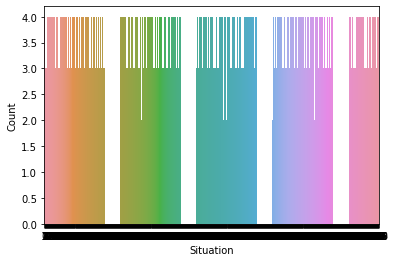

In [63]:
sns.barplot(x="Situation", y="Count", data=df_refs_uniq)

<AxesSubplot:xlabel='Count', ylabel='Count'>

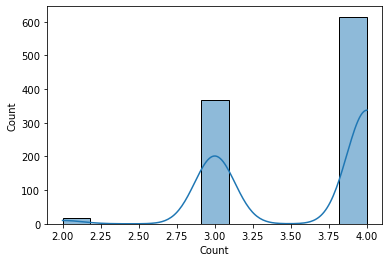

In [64]:
sns.histplot(df_refs_uniq.Count, kde=True)

Looks like we have a lot situations where 3 or 4 refs are applicable. Since there are 7 scenarios a model have around 40-60% chance to be correct. So we want to see something higher than 60% to allow for something to be learnt.

In [90]:
# The scenarios to distinguish a piece is a fix number (7):
# - by all properties together (1)
# - by one specific property of color, shape and position (3)
# - by a pair of properties color, shape and position (3) (because order does not matter here)
# What is the frequency for each scenario? (Note: A sample may include multiple scenarios based on the props order)
# Here we only count the distinct scenarios.
# Can also be seen as distribution of Y (label frequencies)
def scenario_uniq_freq(tasks):
    freqs = collections.defaultdict(int)
    for task in tasks:
        task_refs = set()
        for ref in task["refs"]:
            # order should not matter (we sort before)
            props = list(ref["props"].keys())
            props.sort()
            task_refs.add(tuple(props)) # list is not hashable, but tuple is
        for tref in task_refs:
            freqs[tref] += 1  # we want to count a scenario only once
    return freqs


scenario_freqs = scenario_uniq_freq(tasks)

In [92]:
df_scenario_freqs = pd.DataFrame.from_records(
    [{"Scenario": idx, "Count": v, "Props": k} for idx, (k,v) in enumerate(scenario_freqs.items())])

In [97]:
for idx, (k,v) in enumerate(scenario_freqs.items()):
    print(idx, k,v )

0 ('shape',) 713
1 ('color', 'posRelBoard') 532
2 ('color', 'shape') 544
3 ('posRelBoard',) 715
4 ('posRelBoard', 'shape') 461
5 ('color',) 599
6 ('color', 'posRelBoard', 'shape') 33


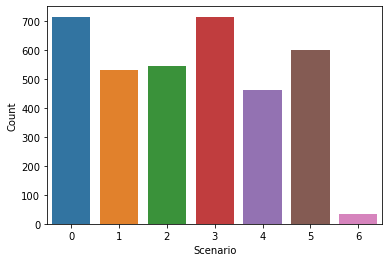

In [93]:
ax = sns.barplot(x="Scenario", y="Count", data=df_scenario_freqs)